In [1]:
getwd()
if ( is.null(environment()$this_notebook_dir) ) {
    this_notebook_dir <- getwd()
    setwd(paste0(getwd(), '/..'))
}
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/NA_fix"

[1] "/mnt/hdd/develop/kaggle/house-prices/R"

In [3]:
source('helpers.R')
source('validation_utils.R')

kaggle.house.loadLibraries()
data <- kaggle.house.loadData()

data$combined %>% 
select(-dataSource) %>% 
filter(!is.na(LotFrontage)) %>% 
mutate(
    LotFrontage.log = log(LotFrontage),
    LotArea.log = log(LotArea)
) -> df.LotFrontage

dataset <- df.LotFrontage %>% select(LotFrontage.log, LotArea.log, MSSubClass)
dataset %>% dim

[1] 2433    3

In [90]:
train_index <- caret::createDataPartition(dataset$LotFrontage.log, p=0.6, times=1, list=FALSE)

trainset <- dataset[train_index,]
testset <- dataset[-train_index,]

c(trainset %>% nrow, testset %>% nrow)

trainset <- trainset %>%
group_by(MSSubClass) %>%
mutate(MSSubClass.avg = median(LotFrontage.log))

train_MSSubClass_group_avg <- trainset %>% summarise(MSSubClass.avg=max(MSSubClass.avg))
train_MSSubClass_global_avg <- trainset %>% ungroup %>% summarise(avg=max(MSSubClass.avg)) %>% `$`('avg')

testset <- testset %>% left_join(train_MSSubClass_group_avg, by='MSSubClass')
testset[is.na(testset$MSSubClass.avg), "MSSubClass.avg"] <- train_MSSubClass_global_avg

trainset %>% head
testset %>% head

model <- trainset %>% 
lm(LotFrontage.log ~ LotArea.log + MSSubClass.avg, data = .)

model %>% summary

y_test_predicted <- predict(model, testset)
y_test_actual <- testset$LotFrontage.log

train_score <- sum(model$residuals^2) / length(model$residuals)
test_score <- sum( (y_test_predicted - y_test_actual)^2 ) / length(y_test_actual)

train_score
test_score

[1] 1462  971

LotFrontage.log,LotArea.log,MSSubClass,MSSubClass.avg
4.382027,9.169518,20,4.317488
4.219508,9.328123,60,4.317488
4.094345,9.164296,70,4.094345
4.442651,9.554993,50,4.094345
4.317488,9.218705,20,4.317488
4.248495,9.323669,20,4.317488


LotFrontage.log,LotArea.log,MSSubClass,MSSubClass.avg
4.174387,9.041922,60,4.317488
4.430817,9.565214,60,4.317488
3.931826,8.719317,50,4.094345
3.912023,8.911934,190,4.118740
4.442651,9.386308,60,4.317488
4.510860,9.273503,20,4.317488



Call:
lm(formula = LotFrontage.log ~ LotArea.log + MSSubClass.avg, 
    data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.01268 -0.09914  0.00229  0.10103  1.13568 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -1.14191    0.10233  -11.16   <2e-16 ***
LotArea.log     0.32858    0.01645   19.97   <2e-16 ***
MSSubClass.avg  0.56220    0.02955   19.03   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2049 on 1459 degrees of freedom
Multiple R-squared:  0.6625,	Adjusted R-squared:  0.6621 
F-statistic:  1432 on 2 and 1459 DF,  p-value: < 2.2e-16


[1] 0.04190424

[1] 0.04489087

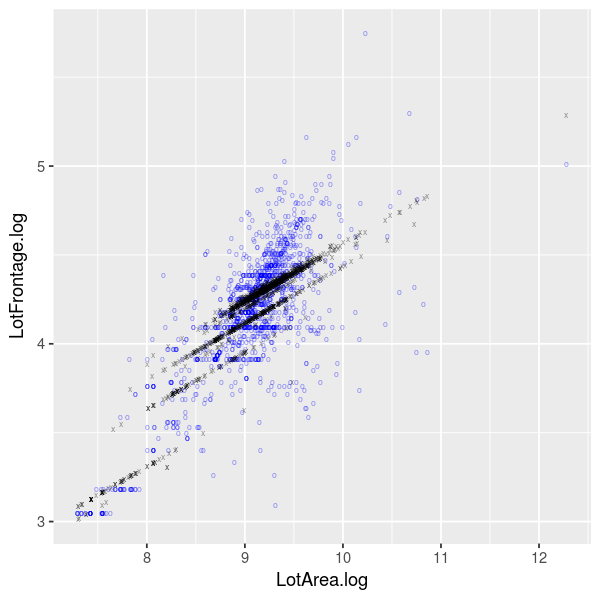

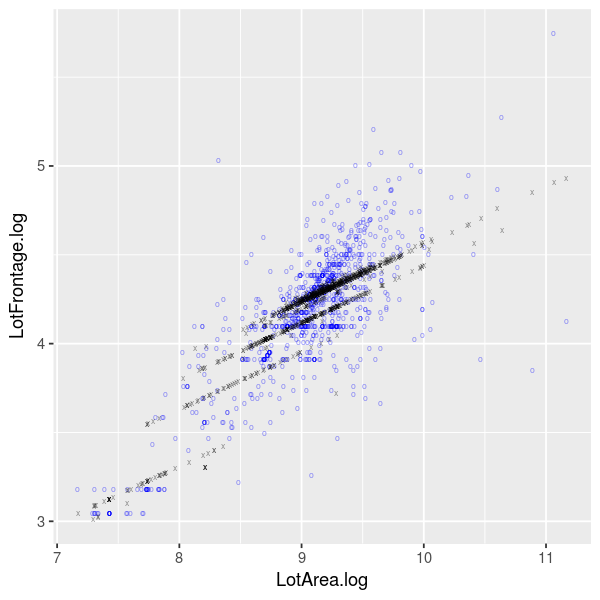

In [84]:
options(repr.plot.width = 5, repr.plot.height = 5)

model.augment <- broom::augment(model)

model.augment %>% 
ggplot() + 
geom_point(aes(x=LotArea.log, y=LotFrontage.log), alpha=0.4, color="blue", shape='o') +
geom_point(aes(x=LotArea.log, y=.fitted), alpha=0.4, color="black", shape='x')

testset %>%
ggplot() + 
geom_point(aes(x=LotArea.log, y=LotFrontage.log), alpha=0.4, color="blue", shape='o') +
geom_point(aes(x=LotArea.log, y=y_test_predicted), alpha=0.4, color="black", shape='x')